# Stating the problem

We want to develop a regime based asset allocation method, therefore we have to:
1. Use an algorithm for regimes identification
2. Smooth the output to avoid "false crashes"
3. Optimize for each scenario
4. Backtest 

In order to complete these tasks I used these models:
1. Hidden Markov Model with Gaussian Mixture emissions
2. Trend Filtering algorithm
3. Mean Variance and Nested Clustered optimization methods
4. Simple backtest with perfect capital market assumptions

# 0. Setup

In [1]:
import pandas as pd
import matplotlib.pyplot   as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import yfinance as yf
from hmmlearn import hmm
import cvxpy as cp

import riskfolio as rp

import warnings

warnings.filterwarnings('ignore')

In [2]:
tickers=['SPY','TIP','GLD','SHY','TLT']
tickers.sort()
data=yf.download(tickers)['Adj Close']

[*********************100%***********************]  5 of 5 completed


In [3]:
split_date='2015-01-01'

In [4]:
returns=data.pct_change().dropna()
train=returns.loc[:split_date]
test=returns.loc[split_date:]

# 1. Hidden Markov Model with Gaussian Mixture emissions

HMM is a generative probabilistic model, in which a sequence of observable $\mathbf{O}$ variables is generated by a sequence of internal hidden states $\mathbf{S}$. The hidden states are not observed directly. The transitions between hidden states are assumed to have the form of a (first-order) Markov chain.

* https://hmmlearn.readthedocs.io/

We have to solve two problems:
1. Given just the observed data, estimate the model parameters (Baum-Welch algorithm)
2. Given the model parameters and observed data, estimate the optimal sequence of hidden states (Viterbi algorithm)


Assumptions:

1. The state at any time $t$ depends on its state at time $t-1$, and is independent of any other moment.
$$
P\left\{S_{t} \mid S_{t-1}, O_{t-1}, \ldots, S_{1}, O_{1}\right\}=P\left\{S_{t} \mid S_{t-1}\right\}
$$
2. The observation of any time $t$ depends on its state at time $t$, and is independent of any others.
$$
P\left\{O_{t} \mid S_{T}, O_{T}, \ldots, S_{1}, O_{1}\right\}=P\left\{O_{t} \mid S_{t}\right\}
$$
3. There are only two regimes which leads to two market phases, denoted as Bull and Bear i.e.
$$
O(\Omega)=\omega \ \ s.t. \ \omega=\{Bull \ or \ Bear\}
$$

We will set the covariance type as *full*, meaning each asset class can have its own distribution

* Mingwen Liu, Junbang Huo, Yulin Wu, Jinge Wu. Stock Market Trend Analysis Using Hidden Markov Model and Long Short Term Memory https://doi.org/10.48550/arXiv.2104.09700

-------------

In [5]:
model=hmm.GMMHMM(n_components=2,n_mix=2,covariance_type='full',random_state=150)

In [6]:
model.fit(np.array(train))

GMMHMM(covariance_type='full',
       covars_prior=array([[[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]],


       [[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]]]),
       covars_weight=array([[-7., -7.],
       [-7., -7.]]),
       means_prior=array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]]),
       means_weight=array([[0., 0.],
       [0., 0.]]), n_components=2, n_mix=2,
       random_state=150, weights_prior=array([[1., 1.],
       [1., 1.]]))

## In sample

In [7]:
res_train=train.copy()
res_train['state']=model.predict(np.array(train))

In [8]:
sns.set(rc={'figure.figsize':(12,5)})

def plot_regimes_hist(x,asset='SPY'):
    sns.histplot(x[x['state']==0],x=asset,stat='density',bins=100,color='blue',kde=True)
    sns.histplot(x[x['state']==1],x=asset,stat='density',bins=100,color='red',kde=True)
    plt.show()

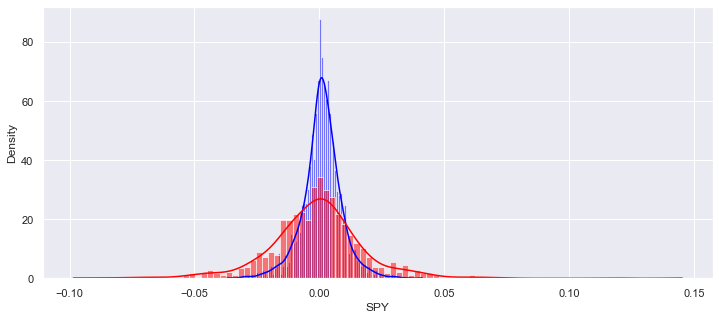

In [9]:
plot_regimes_hist(res_train)

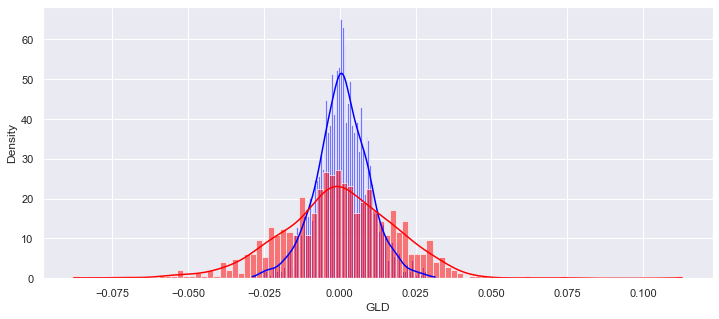

In [10]:
plot_regimes_hist(res_train,'GLD')

# 2. Trend filtering algorithm

\begin{equation*} 
    \hat{\beta} = \text{argmin}_{\beta \in \mathbb{R}^n} ||x-\beta||_2^2 + \lambda||D\beta||_1 .
\end{equation*}

Where:
* $
D =
    \begin{bmatrix}
       1 & -1 & 0 & \dots & 0 & 0  \\
       0  & 1 &-1 & \dots & 0 & 0 \\
       \vdots \\
       0  & 0 & 0 & \dots & -1 & 0\\
       0  & 0 & 0 & \dots & 1 & -1
    \end{bmatrix}
\in \mathbb{R}^{(n-1)\times n}.
$

* $\lambda= 6$

Based on: Ryan J. Tibshirani, 2014. Fast and Flexible ADMM Algorithms for Trend Filtering

In [11]:
def regimes(x,lambdaa,plott=True):
    ptrain=pd.DataFrame(model.predict_proba(x),index=x.index)
    
    betas=trend_filtering(ptrain[1].values,lambdaa)
    smtrain=pd.DataFrame(betas,index=ptrain.index)

    rtrain=pd.DataFrame(index=smtrain.index, columns=['P'])
    rtrain.iloc[smtrain>0.5]=1
    rtrain.iloc[smtrain<0.5]=0

    changing_train=rtrain[rtrain-rtrain.shift(-1)!=0].dropna().index
    changing_train=list(changing_train)

    if plott==True:
        ptrain.plot()
        smtrain.plot()
        
        fig, ax = plt.subplots()
        plt.plot(data['SPY'].loc[x.index])
        for i in range(0,len(changing_train),2):
            try:
                x1=changing_train[i]
                x2=changing_train[i+1]
                ax.axvspan(x1,x2, alpha=0.5, color='red')
            except:
                pass

        plt.show()

    return rtrain, changing_train


In [12]:
def trend_filtering(data,lambda_value):
    
    n = np.size(data)
    x_ret = data.reshape(n)

    Dfull = np.diag([1]*n) - np.diag([1]*(n-1),1)
    D = Dfull[0:(n-1),]

    beta = cp.Variable(n)
    lambd = cp.Parameter(nonneg=True)

    def tf_obj(x,beta,lambd):
        return cp.norm(x-beta,2)**2 + lambd*cp.norm(cp.matmul(D, beta),1)

    problem = cp.Problem(cp.Minimize(tf_obj(x_ret, beta, lambd)))

    lambd.value = lambda_value
    problem.solve()

    return beta.value

## Results

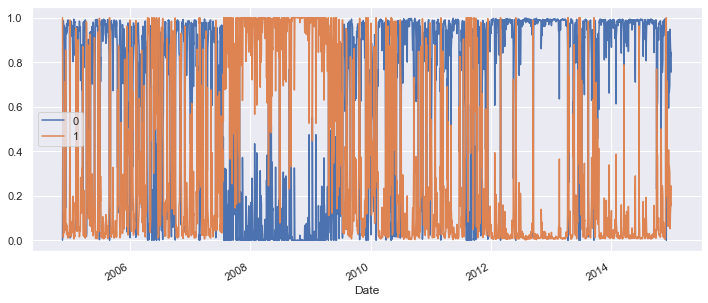

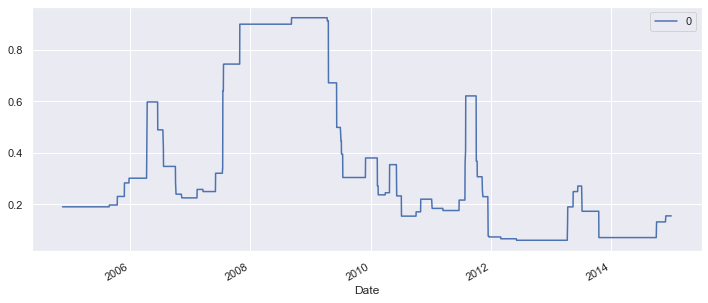

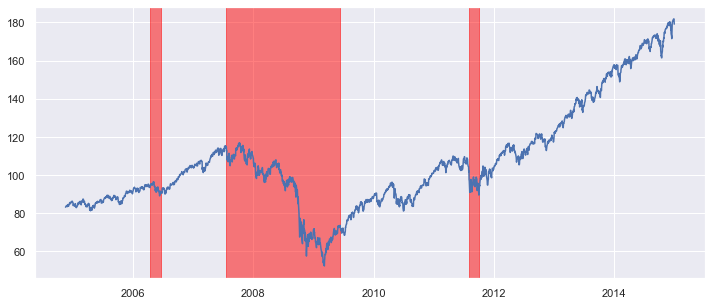

In [13]:
r_train=regimes(train,lambdaa=6)

In [14]:
res_train['state']=r_train[0]
res_train.dropna(inplace=True)

<AxesSubplot:xlabel='state'>

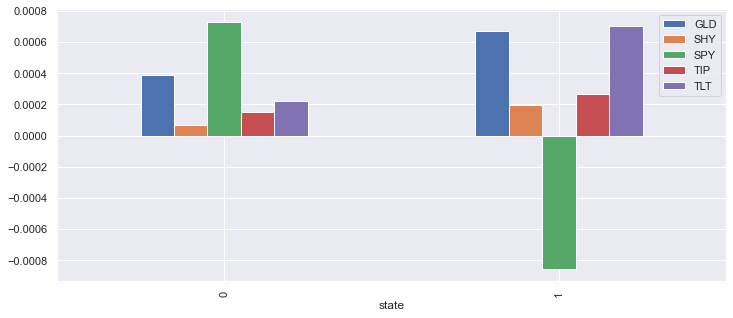

In [15]:
res_train.groupby('state').mean().plot.bar()

## Out of sample

In [16]:
res_test=test.copy()
res_test['state']=model.predict(np.array(test))

In [17]:
model.get_stationary_distribution()

array([0.65886166, 0.34113834])

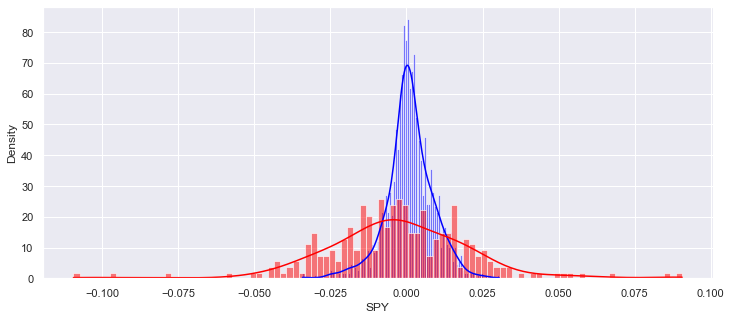

In [18]:
plot_regimes_hist(res_test)

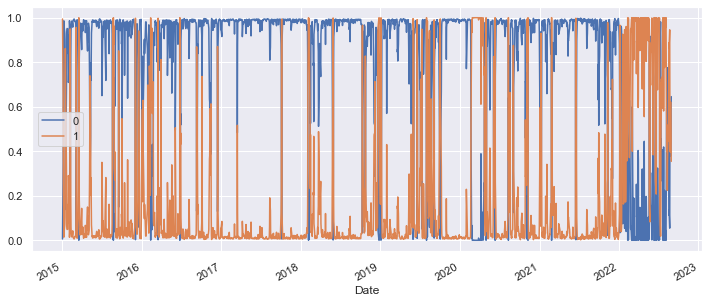

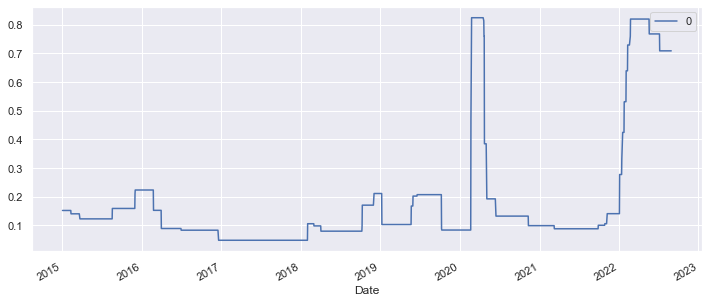

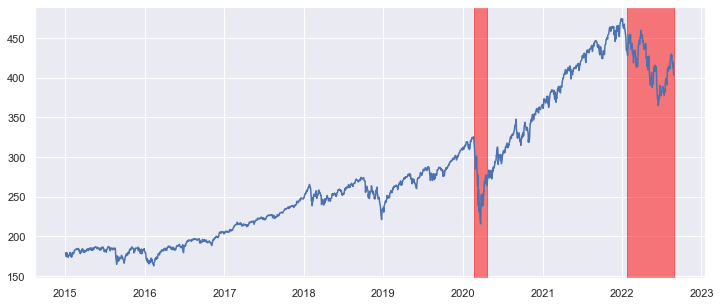

In [19]:
rr1=regimes(test,lambdaa=6)

## 2.1 Preventing Look Ahead bias

In [20]:
from tqdm import tqdm

In [21]:
def regimes1(x,lambdaa):
    ptrain=pd.DataFrame(model.predict_proba(x),index=x.index)
    betas=trend_filtering(ptrain[1].values,lambdaa)

    return betas[-1]

In [22]:
a=[]
for i in tqdm(range(100,len(test),1)):
    a.append(regimes1(test.iloc[:i], lambdaa=6))

100%|██████████| 1828/1828 [01:44<00:00, 17.46it/s]


In [23]:
r_test=pd.DataFrame(a,index=test.iloc[100:].index)
r_test[r_test>0.5]=1
r_test[r_test<=0.5]=0

In [24]:
res_test['state']=r_test

In [25]:
rtrain=res_test['state']
changing_train=rtrain[rtrain-rtrain.shift(-1)!=0].dropna().index
changing_train=list(changing_train)

In [26]:
changing_train

[Timestamp('2020-03-03 00:00:00'),
 Timestamp('2020-05-11 00:00:00'),
 Timestamp('2022-02-24 00:00:00'),
 Timestamp('2022-08-29 00:00:00')]

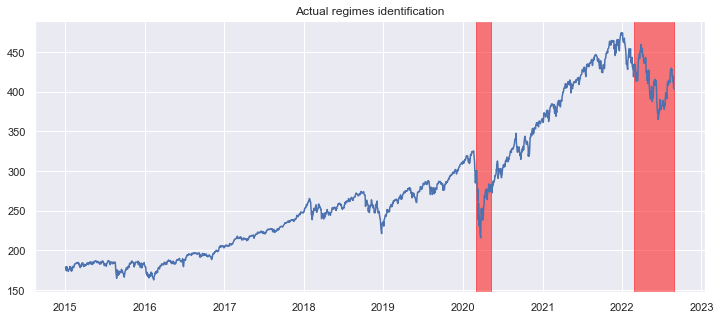

In [27]:
fig, ax = plt.subplots()
plt.plot(data['SPY'].loc[test.index])
for i in range(0,len(changing_train),2):
    x1=changing_train[i]
    x2=changing_train[i+1]
    ax.axvspan(x1,x2, alpha=0.5, color='red')
    plt.title('Actual regimes identification')

plt.show()

## Functions

In [28]:
def backtest_rebal(rets,weights,index_,taxes=0.26):
    index_.append(len(rets)-1)
    first=True
    a=pd.Series()
    c=0
    x=0
    for i in index_:
        if first==True:
            first=False
        else:
            a=pd.concat([(rets.iloc[x:i]@np.array(weights.iloc[c])),a],join='inner')
            c+=1
        x=i

    a.sort_index(inplace=True)

    hist=(a+1).cumprod()

    return hist

In [29]:
def backtest(X):
    hist=[]
    for i in states:
        hist.append(test.iloc[ema-1:][res_test['state']==i]@X.loc[i])
    y=(pd.concat(hist).sort_index()+1).cumprod()
    return y

In [30]:
def taxes(h,rd,taxrate=0.26):
    dd=h[returns1.iloc[rd].index[:-1]].index
    x=pd.DataFrame(h)
    first=True
    for a, b in x.iterrows():
        if first==True:
            first=False
            c=a
        else:
            if a in dd:
                x.loc[a:]=x.loc[a:]-(x.loc[a]/x.loc[c])*(taxrate)
                c=a
    return x

# 3. Optimization

In [31]:
def estimates(Y):
    mu=(Y+1).prod()**(252/len(Y))-1
    sigma=Y.cov()*(252**0.5)
    return mu, sigma

### Rebalancing dates

In [32]:
def rebaldates(rets,n_loockback=250,n_rebal=1):
    index = rets.groupby([rets.index.year, rets.index.month]).tail(1).index
    index_2 = rets.index
    index = [x for x in index if float(x.month) % n_rebal== 0 ] 
    index_ = [index_2.get_loc(x) for x in index if index_2.get_loc(x) > n_loockback]

    return index_,index


In [33]:
def opt(Y,model,l=4,rm='MV'):
    if model=='MV':
        port=rp.Portfolio(Y)
        port.assets_stats(method_mu='hist', method_cov='hist')
        w=port.optimization(model='Classic',obj='Utility',l=l,rm=rm)
    if model=='NCO':
        port=rp.HCPortfolio(Y)
        w=port.optimization(model='NCO',obj='Utility',covariance='fixed',l=l,rm=rm)
    return w

In [34]:
returns1=pd.concat([res_test,res_train]).sort_index().dropna()

def optimization(returns1,model,rm='MV',l=6):
    weights = pd.DataFrame([])
    dates,index=rebaldates(returns1)
    first=True
    ok=False
    d=[]
    for i in dates:
        state=returns1.iloc[i]['state']
        if first==True:
            ok=True
            first=False
        else:
            if state!=state1:
                ok=True
            else:
                ok=False
        if ok:
            Y=returns1[returns1['state']==state].drop('state',axis=1)
            w=opt(Y,model,rm=rm,l=l)
            weights = pd.concat([weights, w], axis = 1)
            d.append(str(returns1.iloc[i].name))
        state1=state
        
    r_dates=[returns1.index.get_loc(x) for x in list(returns1.loc[d].index)]
    weights=weights.T
    weights.index=d
    hist=backtest_rebal(returns1.drop('state',axis=1),weights,r_dates) 


    return weights,hist

## RBAA Variance
### Mean Variance

$$
\begin{array}{ll}
\max _{w} & R(w)-\lambda \phi_{k}(w) \\
\end{array}
$$

where
* $\lambda$ is the risk adversion parameter which, in this analysis, will be 6 and 10
* $\phi$ is is the risk measure, we will consider the variance in this notebook
* $R(w)$ is the expected portfolio return

In [35]:
taxes(hmv4,rd).plot()

NameError: name 'hmv4' is not defined

<AxesSubplot:>

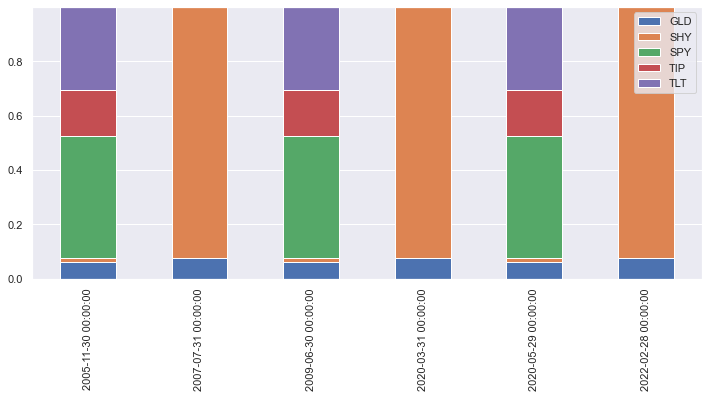

In [ ]:
# risk adv factor=10
mv4,hmv4=optimization(returns1,model='MV',l=10)
mv4.plot.bar(stacked=True)

### NCO

*doi:10.2139/ssrn.3469961* - Marco Lopez De Prado, A robust estimator of the efficient frontier

<AxesSubplot:>

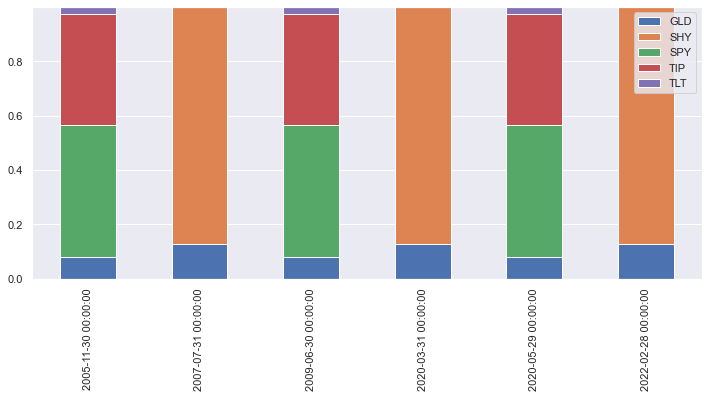

In [ ]:
wnco2,hnco2=optimization(returns1,model='NCO')
wnco2.plot.bar(stacked=True)

<AxesSubplot:>

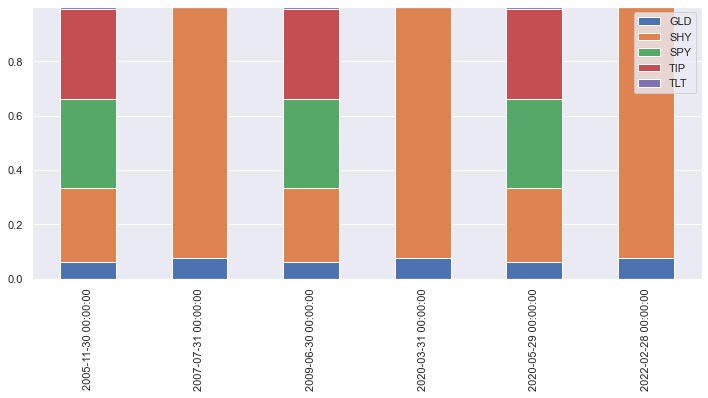

In [ ]:
wnco4,hnco4=optimization(returns1,model='NCO',rm='MV',l=10)
wnco4.plot.bar(stacked=True)

## Uniperiodal

In [ ]:
def uniperdiodal_backtest(w,returns):
    hist=(returns@w+1).cumprod()
    return hist

In [ ]:
retss=returns1.drop('state',axis=1)

umv4=opt(train,model='MV',l=10)
h_mv4=uniperdiodal_backtest(umv4,retss)

unco4=opt(train,model='NCO',l=10)
h_nco4=uniperdiodal_backtest(unco4,retss)


<AxesSubplot:>

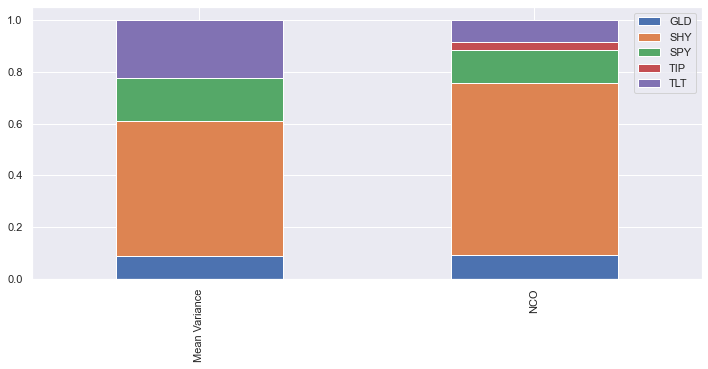

In [ ]:
pd.concat([umv4,unco4],axis=1).set_axis(['Mean Variance','NCO'],axis=1).T.plot.bar(stacked=True)

### 60/40

In [ ]:
w6040=[0,0.2,0.4,0.1,0.3]

In [ ]:
h6040=uniperdiodal_backtest(w6040,retss)

## Other functions

In [ ]:
def drawdown(x):
    running_max = np.maximum.accumulate(x)
    dd = x / running_max - 1 
    return dd

In [ ]:
def computestats(x):
    std=x.pct_change().dropna().std()*(252**0.5)
    cagr=(x[-1]/x[0])**(252/len(x))-1
    sharpe=cagr/std
    neg_std=(x.pct_change()[x.pct_change() < x.pct_change().mean()].std())*(252**0.5)
    sortino=(cagr)/ neg_std
    dd=drawdown(x).min()
    return cagr,std,sharpe,sortino,dd

# 4. Backtest

In [ ]:
def split(hist,x=split_date,scale=True,std=0.05):
    hist=(hist.loc[x:])
    if scale:
        h_std=hist.pct_change().dropna().std()*(252**0.5)
        h_pct=hist.pct_change()*(std/h_std)
        hist=(1+h_pct).cumprod()
    else:
        hist=(1+hist.pct_change()).cumprod()
    hist.iloc[0]=1
    return hist

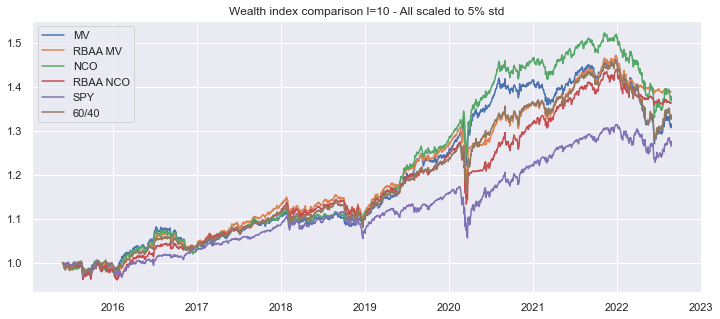

In [ ]:
plt.plot(split(h_mv4),label='MV')
plt.plot(split(hmv4),label='RBAA MV')
plt.plot(split(h_nco4),label='NCO')
plt.plot(split(hnco4),label='RBAA NCO')
plt.plot(split(data['SPY'],x=split(hnco2).index[0]),label='SPY')
plt.plot(split(h6040),label='60/40')
plt.legend()
plt.title('Wealth index comparison l=10 - All scaled to 5% std')
plt.show()

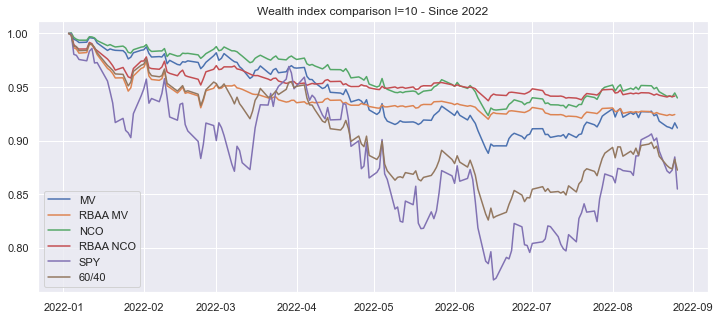

In [ ]:
import datetime
x='2022'
plt.plot(split(h_mv4,x=x,scale=False),label='MV')
plt.plot(split(hmv4,x=x,scale=False),label='RBAA MV')
plt.plot(split(h_nco4,x=x,scale=False),label='NCO')
plt.plot(split(hnco4,x=x,scale=False),label='RBAA NCO')
plt.plot(split(data['SPY'],x=x,scale=False),label='SPY')
plt.plot(split(h6040,x=x,scale=False),label='60/40')
plt.legend()
plt.title('Wealth index comparison l=10 - Since 2022')
plt.show()

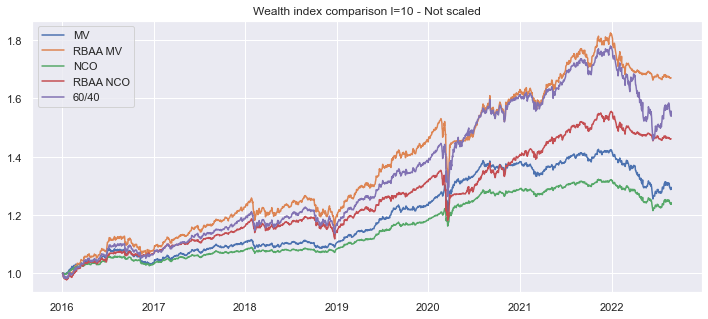

In [ ]:
x='2016'
plt.plot(split(h_mv4,x=x,scale=False),label='MV')
plt.plot(split(hmv4,x=x,scale=False),label='RBAA MV')
plt.plot(split(h_nco4,x=x,scale=False),label='NCO')
plt.plot(split(hnco4,x=x,scale=False),label='RBAA NCO')
plt.plot(split(h6040,x=x,scale=False),label='60/40')
plt.legend()
plt.title('Wealth index comparison l=10 - Not scaled')
plt.show()

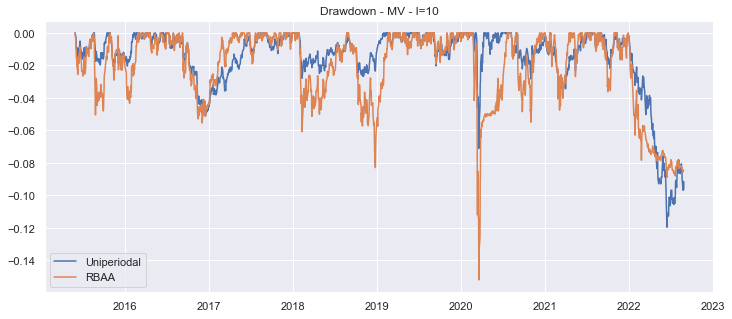

In [ ]:
plt.plot(drawdown(split(h_mv4,scale=False)),label='Uniperiodal')
plt.plot(drawdown(split(hmv4,scale=False)),label='RBAA')
plt.legend()
plt.title('Drawdown - MV - l=10')
plt.show()


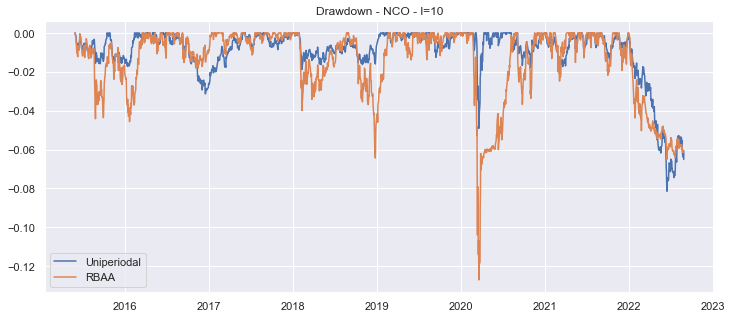

In [ ]:
plt.plot(drawdown(split(h_nco4,scale=False)),label='Uniperiodal')
plt.plot(drawdown(split(hnco4,scale=False)),label='RBAA')
plt.legend()
plt.title('Drawdown - NCO - l=10')
plt.show()


# Stats

In [ ]:
l=[hmv4,h_mv4.iloc[:,0],hnco4,h_nco4.iloc[:,0],(test['SPY']+1).cumprod(),h6040]
a=[]

for i in range(0,len(l)):
    l[i]=split(l[i],scale=False)
    
for i in l:
    a.append(computestats(i))

results=pd.DataFrame(a,index=['MV RBAA','MV','NCO RBAA', 'NCO','SPY','6040'],columns=['CAGR','STD','Sharpe','Sortino','Max DD'])
results.sort_values('Sharpe',ascending=False)

,CAGR,STD,Sharpe,Sortino,Max DD
MV RBAA,0.070424,0.076155,0.924743,1.095236,-0.151995
NCO,0.027937,0.031581,0.884618,1.125234,-0.081435
NCO RBAA,0.050313,0.057675,0.872349,0.993552,-0.127029
6040,0.059660,0.075714,0.787962,0.948108,-0.181726
MV,0.033994,0.045022,0.755053,0.961209,-0.119558
SPY,0.112788,0.183125,0.615907,0.731027,-0.337173


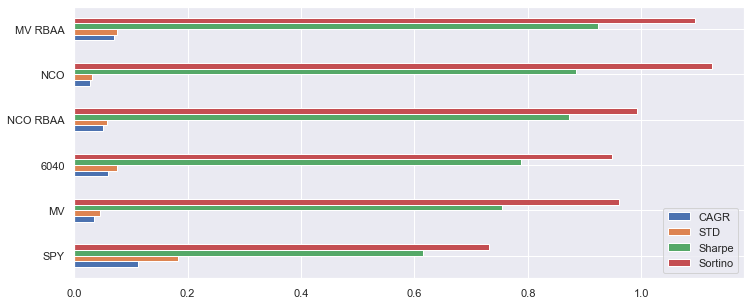

In [ ]:
results.sort_values('Sharpe').drop('Max DD', axis=1).plot.barh()
plt.show()

<AxesSubplot:title={'center':'|Max DD|/CAGR'}>

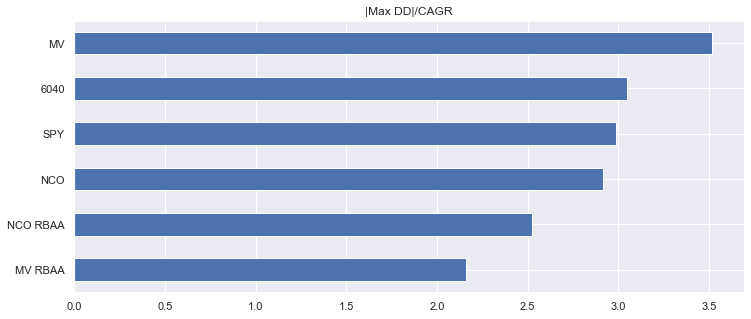

In [ ]:
(-results['Max DD']/results['CAGR']).sort_values().plot.barh(title='|Max DD|/CAGR')

# Further work

Below is reported the necessary further work to make this empirical experiment complete:
* Violate capital market assumptions, introducing transaction and slippage costs
* Extend the analysis with longer timeseries
* Experiment with multiple regimes
* Introduce a Constant proportion portfolio insurance
* Consider the impact on taxes and its implication for retail investors